# **Preview of kingsk4 Data**

In [1]:
import pandas as pd

df_meta = pd.read_csv('../Data/Gold/kingsk4_meta_gold.csv')
df_moves = pd.read_csv('../Data/Gold/kingsk4_moves_gold.csv')

In [2]:
df_meta.head(3)

,game_id,Date,White,Black,Result,ECO,WhiteElo,BlackElo,TimeControl,Termination,Tournament,StartDateTime,EndDateTime
0,1,2025.11.22,G3rHaN4,kingsk4,1,A00,665,649,300,2,NaN,11/22/2025 2:01,11/22/2025 2:11
1,2,2025.11.22,MaximumElvis,kingsk4,0,B07,629,661,300,0,NaN,11/22/2025 0:22,11/22/2025 0:31
2,3,2025.11.21,kingsk4,jesus-shuttlesworth33,1,D00,650,638,300,0,NaN,11/21/2025 1:56,11/21/2025 2:00


In [3]:
df_moves.head(3)

,game_id,ply,color,move,clock,eval,fen
0,1,1,True,c3,0:04:59,-0.07,rnbqkbnr/pppppppp/8/8/8/2P5/PP1PPPPP/RNBQKBNR ...
1,1,2,False,d6,0:04:57.6,0.15,rnbqkbnr/ppp1pppp/3p4/8/8/2P5/PP1PPPPP/RNBQKBN...
2,1,3,True,e3,0:04:57.7,-0.15,rnbqkbnr/ppp1pppp/3p4/8/8/2P1P3/PP1P1PPP/RNBQK...


## First degree termination insights

In [4]:
# Inverse mapping for termination codes
inv_term_map = {
    0: 'won by checkmate',
    1: 'won by resignation',
    2: 'won on time',
    3: 'won - game abandoned',
    4: 'game drawn by stalemate',
    5: 'game drawn by repetition',
    6: 'game drawn by insufficient material',
    7: 'game drawn by 50-move rule',
    8: 'game drawn by timeout vs insufficient material',
    9: 'game drawn by agreement'
}

termination = df_meta['Termination'].value_counts()
termination = termination.rename(index=inv_term_map)
print(termination)

Termination
won by checkmate                                  1647
won on time                                       1532
won by resignation                                 597
won - game abandoned                               347
game drawn by stalemate                             62
game drawn by repetition                            34
game drawn by insufficient material                 30
game drawn by timeout vs insufficient material      26
game drawn by agreement                              7
Name: count, dtype: int64


Termination pie chart - first attempt

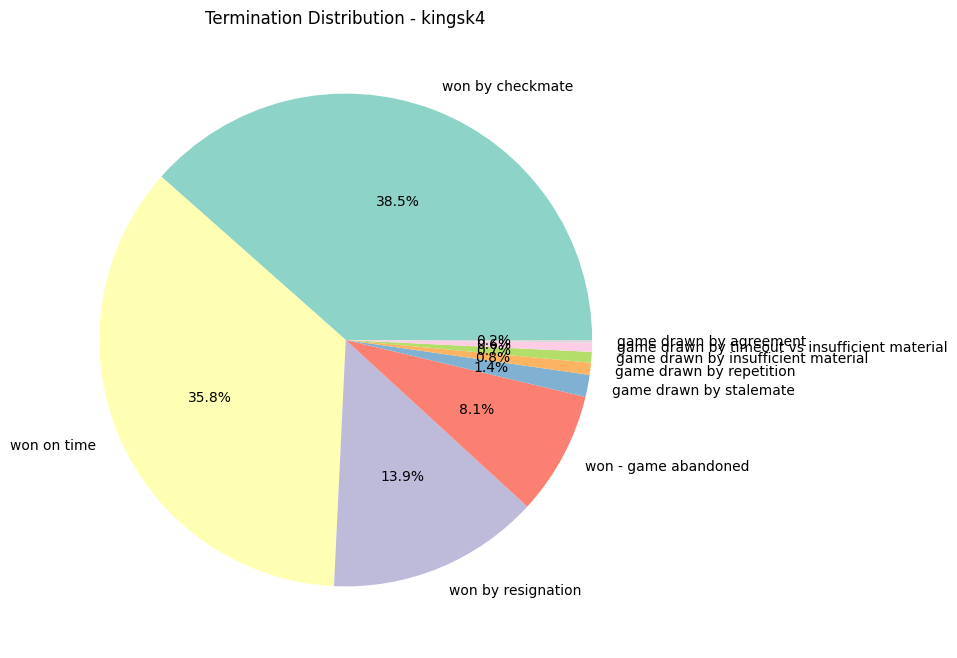

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(range(len(termination)))
termination.plot.pie(autopct='%1.1f%%',
                     title = 'Termination Distribution - kingsk4',
                     colors=colors)
plt.ylabel('')
plt.show()

Termination pie chart - second attempt

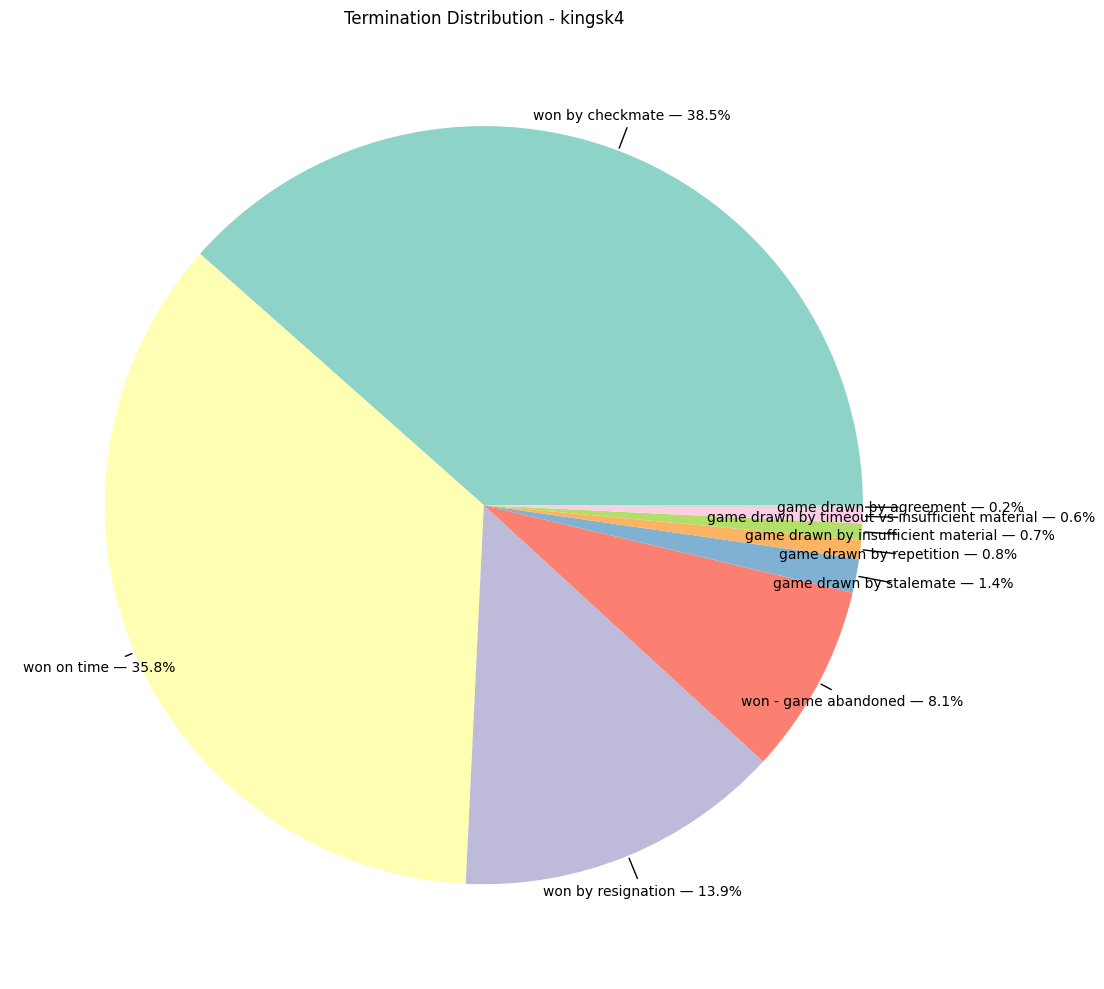

In [6]:
import numpy as np

fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.Set3(range(len(termination)))

values = termination.values
labels = termination.index

# Compute percentage text yourself
percent_labels = [f"{lab} — {val / values.sum() * 100:.1f}%" 
                  for lab, val in zip(labels, values)]

# Draw pie WITHOUT autopct
wedges, _ = ax.pie(
    values,
    colors=colors,
    labeldistance=1.25,   # push labels outside → leader lines appear
)

# Now add external labels with lines to slices
for w, txt in zip(wedges, percent_labels):
    ang = (w.theta2 + w.theta1) / 2
    x = 1.1 * np.cos(np.deg2rad(ang))
    y = 1.1 * np.sin(np.deg2rad(ang))

    ax.annotate(
        txt,
        xy=(np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))),  # pie edge
        xytext=(x, y),                                         # label position
        ha="center",
        va="center",
        arrowprops=dict(arrowstyle="-", lw=1),                 # leader line
    )

ax.set_title("Termination Distribution - kingsk4")
ax.set_ylabel("")

plt.tight_layout()
plt.show()


In [7]:
eco_codes = pd.read_csv('../Analysis/eco_codes.csv',header=None, names=['ECO', 'Opening_Name'])
eco_codes.head(3)

,ECO,Opening_Name
0,A00,Irregular Openings
1,A01,"Larsen's Opening, 1. b3"
2,A02,"Bird's Opening, 1. f4"


In [8]:
# Convert ECO code dataframe to a mapping dictionary
eco_map = eco_codes.set_index("ECO")["Opening_Name"].to_dict()
eco_map = {k:v.split('(including')[0].strip() for k, v in eco_map.items()}
eco_map = {k:v.split('(includes')[0].strip() for k, v in eco_map.items()}

Opening frequencies

In [9]:
openings = df_meta['ECO'].value_counts()
# openings = openings.rename(index=eco_map)
print(openings.head())

ECO
D00    706
B07    654
A40    506
D02    444
C20    371
Name: count, dtype: int64


Success by ECO opening code

In [10]:
username = "kingsk4"

def get_protagonist_result(row):
    if row["White"] == username:
        return row["Result"]
    if row["Black"] == username:
        if row["Result"] == 1:
            return 0
        if row["Result"] == 0:
            return 1
        return 2
    return None  # or np.nan if the player isn't in the game

df_meta["ProtagonistResult"] = df_meta.apply(get_protagonist_result, axis=1)
display(df_meta[["White", "Black", "Result", "ProtagonistResult"]].head(10))


,White,Black,Result,ProtagonistResult
0,G3rHaN4,kingsk4,1,0
1,MaximumElvis,kingsk4,0,1
2,kingsk4,jesus-shuttlesworth33,1,1
3,vince_1001,kingsk4,0,1
4,kingsk4,rvanugget,0,0
5,kingsk4,tusharcs,0,0
6,rscranton,kingsk4,1,0
7,kingsk4,the_best1987,0,0
8,gatone1,kingsk4,1,0
9,DeepChess2004,kingsk4,1,0


In [11]:
eco_win_rates = (
    df_meta.groupby("ECO")["ProtagonistResult"]
    .apply(lambda s: (s == 1).mean())
    .sort_values(ascending=False)
)
# eco_win_rates = eco_win_rates.rename(index=eco_map)
print(eco_win_rates.head())

ECO
A11    1.0
B04    1.0
A50    1.0
A54    1.0
B09    1.0
Name: ProtagonistResult, dtype: float64


Visualize success rate vs games played (grouped by opening)

In [12]:
success = pd.concat([openings, eco_win_rates], axis=1)
display(success.head())

,count,ProtagonistResult
ECO,,
D00,706,0.538244
B07,654,0.498471
A40,506,0.494071
D02,444,0.511261
C20,371,0.528302


In [13]:
# Sort by ProtagonistResult and remove openings played fewer than 3 times
success_result = success.sort_values("ProtagonistResult", ascending=False)
success_result = success_result[success_result['count'] >= 4]
success_result = success_result[success_result['ProtagonistResult'] > 0.5]

# Map ECO code to opening names
success_result = success_result.rename(index=eco_map)

# Renaming for clarity
success_result.columns = ['Games Played', 'Win Rate']
success_result.index.name = 'Opening'

display(success_result.head(30))


,Games Played,Win Rate
Opening,,
"Caro-Kann, Two knights, 3...Bg4",4,0.750000
King's Pawn Game,21,0.666667
Queen's Pawn Game,31,0.612903
Alekhine's Defence,23,0.608696
"English, 1...Nf6 (Anglo-Indian defence)",5,0.600000
Old Indian Defence,10,0.600000
"Ruy Lopez, Old Steinitz Defence",5,0.600000
"Vienna Game, Falkbeer Variation",7,0.571429
Three Knights Game including M�ller-Schulze Gambit or Halloween Attack,16,0.562500
